# Final project GenAI

LEARNING GRADIENTS OF CONVEX FUNCTIONS WITH MONOTONE GRADIENT NETWORKS

arXiv:2301.10862v2

Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from matplotlib.image import imread

import torch
import torch.nn as nn
import torch.nn.functional as F

SetUp

In [2]:
# Set default tensor type to FloatTensor
torch.set_default_dtype(torch.float64)

# default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')
  
# default tensor type  
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


/home/benjamin.deporte/.conda/envs/learning_gradients/lib/python3.12/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/envs/bld/conda-bld/libtorch_1741644046984/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [3]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

### Model classes

C-MGN : Note that the nn.Parameter in PyTorch is what allows to share a weight matrix within the model

In [4]:
class CMGN(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim):
        super(CMGN, self).__init__()
        """Constructor. 
        - input_dim: int, dimension of input data
        - output_dim: int, dimension of output data
        - num_layers: int, number of layers in the model
        - hidden_dim: int, dimension of hidden layers
        """
        self.num_layers = num_layers
        # nn.ModuleList : "Holds submodules in a list" (PyTorch documentation)
        self.sigma_layers = nn.ModuleList([nn.Sigmoid() for _ in range(num_layers)])
        # nn.Parameter : "A kind of Tensor that is to be considered a module parameter." (PyTorch documentation)
        # this is how we create a weight matrix that is shared across all layers
        # NB : requires_grad=True by default
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim)) 
        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.b_L = nn.Parameter(torch.randn(output_dim))
        # nn.ParameterList : "Holds parameters in a list" (PyTorch documentation)
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_layers)])

    def forward(self, x):
        """Forward pass of the model.

        Args:
            x (tensor): input data. Shape (batch_size, input_dim)
        Returns:
            output (tensor) : output data. Shape (batch_size, output_dim)
        """

        # compute z_0
        Wx = F.linear(x, self.W)
        z = Wx + self.biases[0] 
        # compute z_1, z_2, ..., z_{L-1} with the shared weight matrix W
        for i in range(1,self.num_layers):
            z = Wx + self.sigma_layers[i-1](z) + self.biases[i]
        # compute V^T V x
        VTVx = F.linear(F.linear(x, self.V.t()), self.V)
        # compute W sigma_L
        Wsigma = F.linear(self.sigma_layers[self.num_layers-1](z), self.W.T)
        # add everything together
        output = Wsigma + VTVx + self.b_L
        
        return output

M-MGN

In [5]:
# s_k : from the paper, log cosh
def s_k(x):
    return torch.sum(torch.log(torch.cosh(x)) )

class MMGN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, hidden_dim):
        super(MMGN, self).__init__()
        """Constructor. Same wording as C-MGN
        - input_dim: int, dimension of input data
        - output_dim: int, dimension of output data
        - num_modules: int, number of modules in parallel
        - hidden_dim: int, dimension of hidden layers
        """
        self.num_modules = num_modules
        self.W_list = nn.ParameterList([nn.Parameter(torch.randn(input_dim, hidden_dim)) for _ in range(num_modules)])
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_modules)])
        # activation function : from the paper
        self.activation = nn.Tanh()

        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.a = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):

        sum = 0
        for k in range(self.num_modules):
            z_k = F.linear(x, self.W_list[k].T) + self.biases[k]
            Wsigma = F.linear(self.activation(z_k), self.W_list[k])
            sum += s_k(z) * Wsigma
        VTVx = F.linear(F.linear(x, self.V), self.V.t())

        output = self.a + VTVx + sum 
        return output

# Toy Case #1 : Gradient field experiment

Gradient field experiment from the paper.

The convex function is $f: \mathbb{R}^2 \rightarrow \mathbb{R}$:
\begin{equation}
f(x_1,x_2) = x_1^4 + \frac{x_1^2}{2} +  \frac{x_1 x_2}{2}  + \frac{3x_2^2}{2} -  \frac{x_2^3}{3}
\end{equation}

The gradient field to learn, ie the transport map, is:
\begin{equation}
T(x_1,x_2) = \begin{pmatrix}
4x_1^3 + \frac{1}{2}x_2 + x_1 \\
3x_2 - x_2^2 + \frac{1}{2}x_1
\end{pmatrix}
\end{equation}

In [6]:
def f(z):
  # convex function
  x_1 = z[:,0]
  x_2 = z[:,1]
  return torch.stack([x_1**4 + 0.5*x_1**2 + 0.5*x_1*x_2 + 3/2*x_2**2 - x_2**3/3]).T

In [7]:
def g(z):
    # gradient field
    x_1 = z[:,0]
    x_2 = z[:,1]
    return torch.stack([4*x_1**3 + 1/2*x_2 + x_1, 3*x_2 - x_2**2 + 1/2*x_1 ]).T

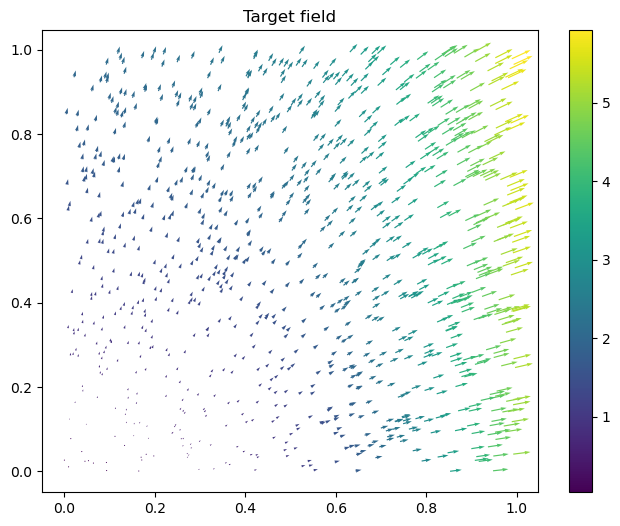

In [8]:
# Plot field (gradient)
space = torch.rand(size=(1000,2)).cpu()
fig,ax = plt.subplots(1,1,figsize=(8,6))

z = g(space)
p = ax.quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1))
ax.set_title('Target field')
plt.colorbar(p)
plt.show()

In [9]:
def train_gradient_field(mod,num_epochs=10000,dim=2,batch_size=100,lr=1e-2):
    optimizer = torch.optim.Adam(mod.parameters(),lr=lr)
    losses = []
    
    for i in range(num_epochs):
        input = torch.rand(size=(batch_size,dim))
        out = mod(input)
        target = g(input)

        loss = (out - target).abs().sum() / batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 1000 == 0: 
            print(f"epoch {i+1}/{num_epochs}, loss = {loss.item():4e}", end="\r")
        losses.append(loss.item())
        
    return losses

In [10]:
model_MMGN = MMGN(input_dim=2, output_dim=2, num_modules=1, hidden_dim=4)
model_CMGN = CMGN(input_dim=2, output_dim=2, num_layers=2, hidden_dim=2)

dim = 2
bsize = 100
epochs_cmgn = 5000
epochs_mmgn = 40000

print("Training C-MGN...")
# summary_model(model_CMGN)
losses_cmgn = train_gradient_field(model_CMGN,num_epochs=epochs_cmgn,dim=dim,batch_size=bsize)

print()
print("Training M-MGN...")
# summary_model(model_MMGN)
losses_mmgn = train_gradient_field(model_MMGN,num_epochs=epochs_mmgn,dim=dim,batch_size=bsize, lr=1e-3)

Training C-MGN...
epoch 5000/5000, loss = 2.775675e-02
Training M-MGN...


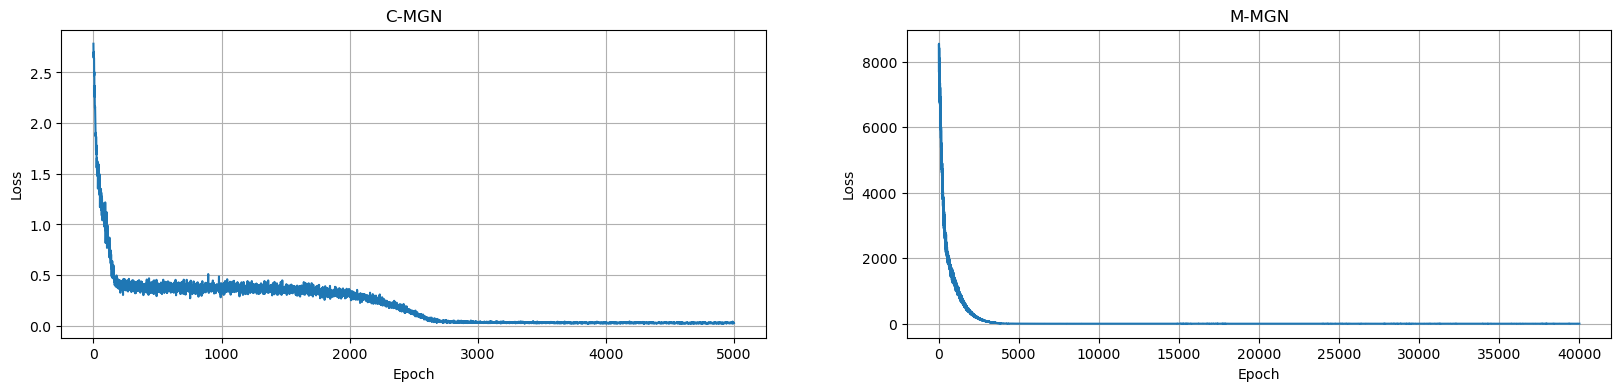

In [11]:
# display training losses
fig, ax = plt.subplots(1,2,figsize=(20,4))

ax[0].plot(losses_cmgn)
ax[0].set_title("C-MGN")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(losses_mmgn)
ax[1].set_title("M-MGN")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].grid()

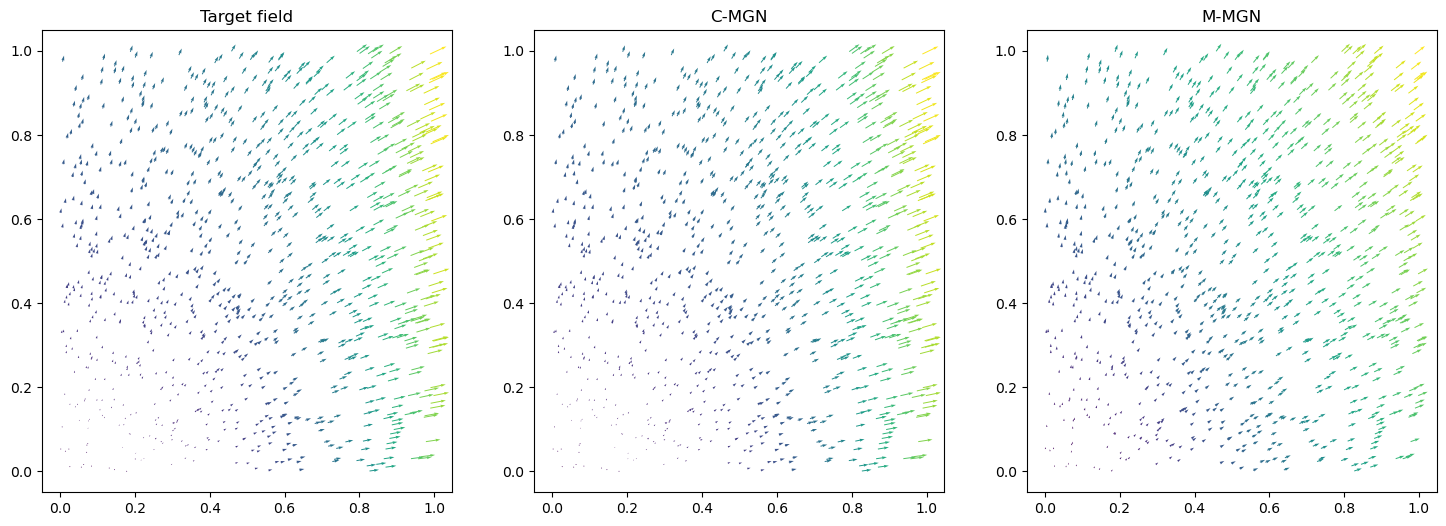

In [12]:
# Visualize the learned fields
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

# calculate fields
space = torch.rand(size=(1000,2)).to(device)
z = g(space)
z_c = model_CMGN(space)
z_m = model_MMGN(space)

# move to cpu for plotting
space = space.cpu()
z = z.cpu()
z_c = z_c.detach().cpu()
z_m = z_m.detach().cpu()

# true gradient field
z = g(space).cpu()
p = axs[0].quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1))
axs[0].set_title('Target field')
# axs[0].colorbar(p)

# C-MGN
p = axs[1].quiver(space[:,0],space[:,1], z_c[:,0],z_c[:,1],z_c.norm(dim=1))
axs[1].set_title('C-MGN')
# axs[1].colorbar(p)

# M-MGN
p = axs[2].quiver(space[:,0],space[:,1], z_m[:,0],z_m[:,1],z_m.norm(dim=1))
axs[2].set_title('M-MGN')
# axs[2].colorbar(p)

plt.show()

## Summary of Toy Case #1 :

- both models C-MGN and M-MGN were able to learn the gradient field
- with the given set of parameters (ie 2 layers for C-MGN and 1 module for M-MGN), the convergence is much faster with C-MGN

# Toy Case 2 : Transporting one Gaussian to another

We want to transport a source 2D Gaussian $\mathcal{N}(\mu_s = [0.0,0.0], \Sigma_s=2*\text{Id})$ to a destination 2D Gaussian $\mathcal{N}(\mu_d, \Sigma_d)$.

The transport is learnt by the models C-MGN and M-MGN with the following losses:
- Wasserstein-2 distance
- KL divergence

We also compute the transport cost.

In [13]:
# source distribution
mu_s = torch.tensor([0.,0.])
cov_s = torch.tensor([[2.,0.],[0.,2.]])

# target distribution
mu_t = torch.tensor([-2.,-2.])
diag_t = torch.tensor([[3.0, 0.0],[0.0, 0.01]])
theta = -torch.tensor(torch.pi/3)
rot_t = torch.tensor([[torch.cos(theta), -torch.sin(theta)],[torch.sin(theta), torch.cos(theta)]])
cov_t = torch.mm(torch.mm(rot_t,diag_t),rot_t.t())

print(f"covariance matrix of the target distribution:")
print(f"{cov_t}")

covariance matrix of the target distribution:
tensor([[ 0.7575, -1.2947],
        [-1.2947,  2.2525]])


In [14]:
def sample_gaussian(mu, cov, n_samples):
    # using torch.distributions to get n samples from the Gaussian mu,cov
    return torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=cov).sample((n_samples,))

In [15]:
def two_plots(z_1, z_2, name_1="source", name_2="current"):
    """Utility function to display the two Gaussians side by side.

    Args:
    z_1 (torch.tensor, shape n x 2): points Gaussian 1
    z_2 (torch.tensor, shape n x 2): points Gaussian 2
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].scatter(z_1[:, 0], z_1[:, 1], s=5)
    axs[0].set_title(name_1)
    axs[0].set_xlim(-5, 5)
    axs[0].set_ylim(-5, 5)
    axs[0].grid()

    axs[1].scatter(z_2[:, 0], z_2[:, 1], s=5)
    axs[1].set_title(name_2)
    axs[1].set_xlim(-5, 5)
    axs[1].set_ylim(-5, 5)
    axs[1].grid()

    plt.show()

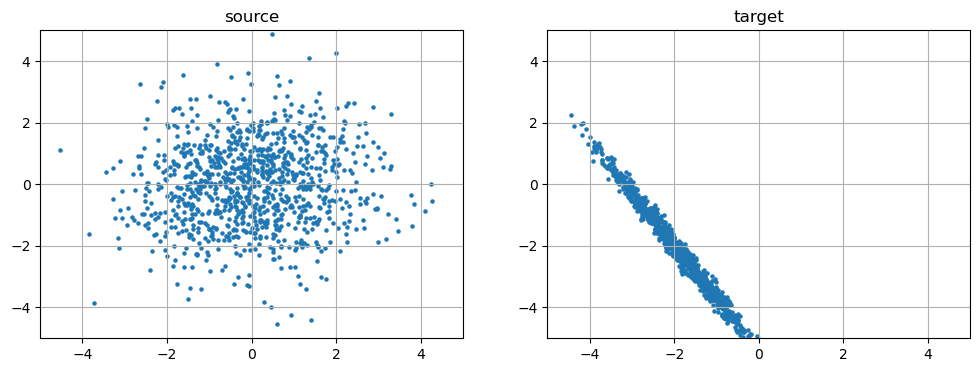

In [16]:
z_1 = sample_gaussian(mu_s, cov_s, 1000).cpu()
z_2 = sample_gaussian(mu_t, cov_t, 1000).cpu()
two_plots(z_1, z_2, name_2='target')

Wasserstein 2 distance between two Gaussians $\mathcal{N}_1(\mu_1, \Sigma_1)$ and $\mathcal{N}_2(\mu_2, \Sigma_2)$:

\begin{align*}
\mathcal{W}(\mathcal{N}_1, \mathcal{N}_2) = \vert\vert \mu_1 - \mu_2 \vert\vert_2^2 + \text{Trace} \,\, \left( \Sigma_1 + \Sigma_2 - 2*(\Sigma_2^{\frac{1}{2}} \Sigma_1 \Sigma_2^{\frac{1}{2}})^{\frac{1}{2}}
    \right)
\end{align*}

In [17]:
def wasserstein_2(mu1, mu2, sigma1, sigma2):
    """Compute the 2-Wasserstein distance between two Gaussians.

    Args:
    mu1 (torch.tensor, shape 2): mean of Gaussian 1
    mu2 (torch.tensor, shape 2): mean of Gaussian 2
    sigma1 (torch.tensor, shape 2 x 2): covariance of Gaussian 1
    sigma2 (torch.tensor, shape 2 x 2): covariance of Gaussian 2

    Returns:
    float: 2-Wasserstein distance
    """
    U, S, Vt = torch.linalg.svd(sigma2)  # sigma 2 = U @ S @ Vt
    racine_sigma2 = torch.mm(torch.mm(U, torch.diag(torch.sqrt(S))), Vt) # sigma2^0.5 = U @ S^0.5 @ Vt
    A = torch.mm(torch.mm(racine_sigma2, sigma1),racine_sigma2) # A = sigma2^0.5 @ sigma1 @ sigma2^0.5
    Ua, Sa, Vta = torch.linalg.svd(A)
    racine_A = torch.mm(torch.mm(Ua, torch.diag(torch.sqrt(Sa))), Vta)
    
    w = torch.sum((mu1-mu2)**2) + torch.trace(sigma1 + sigma2 - 2*racine_A)
    
    return w

KL-Divergence between two Gaussians $\mathcal{N}_1(\mu_1, \Sigma_1)$ and $\mathcal{N}_2(\mu_2, \Sigma_2)$:

\begin{align*}
\mathbb{KL}(\mathcal{N}_1 \vert\vert \mathcal{N}_2) = \frac{1}{2}\left(
    \text{Trace}(\Sigma_2^{-1}\Sigma_1) - k + (\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1) + \text{ln}(\frac{\vert \Sigma_2 \vert}{\vert \Sigma_1 \vert}
    \right)
\end{align*}

where $k$ is the dimensionnality of the two Gaussians

In [18]:
def KL(mu1, mu2, sigma1, sigma2):
    """Compute the Kullback-Leibler divergence between two Gaussians.
    """
    k = mu1.shape[0]  # Dimensionality of the distributions
    sigma2_inv = torch.linalg.inv(sigma2)  # not a ood practice to compute the inverse, but ok for the toy case
    
    kl = 1/2 * (torch.trace(sigma2_inv @ sigma1) - k + (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1) + torch.log(torch.linalg.det(sigma2) / torch.linalg.det(sigma1)))
    
    return kl

Training loop

In [19]:
def train_OT(
    model,  # model to train
    loss_function,  # loss function (either W2 or KL)
    mu_s,  # source distribution mean
    cov_s,  # source distribution covariance
    mu_t,  # target distribution mean
    cov_t,  # target distribution covariance
    num_epochs=5000,  # number of training epochs
    batch_size=1000,  # batch size
    lr=1e-2,  # learning rate
    model_name=None,  # name of the model
    display_frequency=500,  # display frequency
):
    """Train a model to minimize the 2-Wasserstein distance between two Gaussians.

    Args:
    model (nn.Module): model to train
    loss_function (function): either W2 or KL - takes mu1, mu2, sigma1, sigma2 as input
    mu_s (torch.tensor, shape 2): mean of the source distribution
    cov_s (torch.tensor, shape 2 x 2): covariance of the source distribution
    mu_t (torch.tensor, shape 2): mean of the target distribution
    cov_t (torch.tensor, shape 2 x 2): covariance of the target distribution
    num_epochs (int): number of training epochs
    batch_size (int): batch size
    lr (float): learning rate

    Returns:
    list: list of losses
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    norms_delta_mu = []
    norms_delta_cov = []
    transport_costs = []

    for i in range(num_epochs):
        # source distribution
        z_s = sample_gaussian(mu_s, cov_s, batch_size)
        # target distribution
        z_t = sample_gaussian(mu_t, cov_t, batch_size)

        # compute the current transport of the source distribution by the model
        z_s = z_s.to(device)
        z_model = model(z_s)
        mu_model = z_model.mean(dim=0)
        cov_model = torch.mm((z_model - mu_model).T, z_model - mu_model) / batch_size

        # compute the loss wrt the target distribution
        loss = loss_function(mu_t, mu_model, cov_t, cov_model)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute deltas and logs
        norm_delta_mu = torch.norm(mu_t - mu_model).item()
        norm_delta_cov = torch.norm(cov_t - cov_model).item()
        transport_cost = torch.mean((z_model - z_s)**2).item()
        
        losses.append(loss.item())
        norms_delta_mu.append(norm_delta_mu)
        norms_delta_cov.append(norm_delta_cov)
        transport_costs.append(transport_cost)
        
        # donne des nouvelles
        if (i+1) % display_frequency == 0:
            print(f"epoch {i+1}/{num_epochs}, loss = {loss.item():2e}")
            print(f"delta between mus = {torch.norm(mu_t - mu_model).item():.2e}")
            print(f"delta between covs = {torch.norm(cov_t - cov_model).item():.2e}")
            print(f"transport cost = {transport_cost:.2e}")
            print(f"mu model = {mu_model}")
            print(f"cov model = ")
            print(f"{cov_model}")
            print()
        
        # visualize transport
        if (i+1) % display_frequency == 0:
            two_plots(z_t.cpu(), z_model.detach().cpu(), name_1="target", name_2=model_name + f" @ epoch {i+1}")

    return losses, norms_delta_mu, norms_delta_cov, transport_costs

In [20]:
def plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs, main_title=None):
    """Plot the metrics computed during training.

    Args:
    losses (list): list of losses
    norms_delta_mu (list): list of norms of deltas between mus
    norms_delta_cov (list): list of norms of deltas between covs
    transport_costs (list): list of transport costs
    """
    width = 5
    fig, axs = plt.subplots(1, 4, figsize=(width*4, 4))

    axs[0].plot(losses)
    axs[0].set_title("Training loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_yscale("log")
    # axs[0].set_ylabel("Loss")
    axs[0].grid()

    axs[1].plot(norms_delta_mu)
    axs[1].set_title("Norm of delta mu")
    axs[1].set_xlabel("Epoch")
    axs[1].set_yscale("log")
    # axs[1].set_ylabel("Norm")
    axs[1].grid()

    axs[2].plot(norms_delta_cov)
    axs[2].set_title("Norm of delta cov")
    axs[2].set_xlabel("Epoch")
    axs[2].set_yscale("log")
    # axs[2].set_ylabel("Norm")
    axs[2].grid()
    
    axs[3].plot(norms_delta_cov)
    axs[3].set_title("Euclidian transport cost")
    axs[3].set_xlabel("Epoch")
    axs[3].set_yscale("log")
    # axs[2].set_ylabel("Norm")
    axs[3].grid()
    
    if main_title is not None:
        fig.suptitle(main_title)

    plt.show()

### Training networks and learning transport with the Wasserstein-2 distance

C-MGN

Training C-MGN...
epoch 500/3000, loss = 1.004066e-02
delta between mus = 2.26e-02
delta between covs = 1.45e-01
transport cost = 4.81e+00
mu model = tensor([-1.9941, -1.9782], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.8664, -1.3389],
        [-1.3389,  2.1798]], grad_fn=<DivBackward0>)



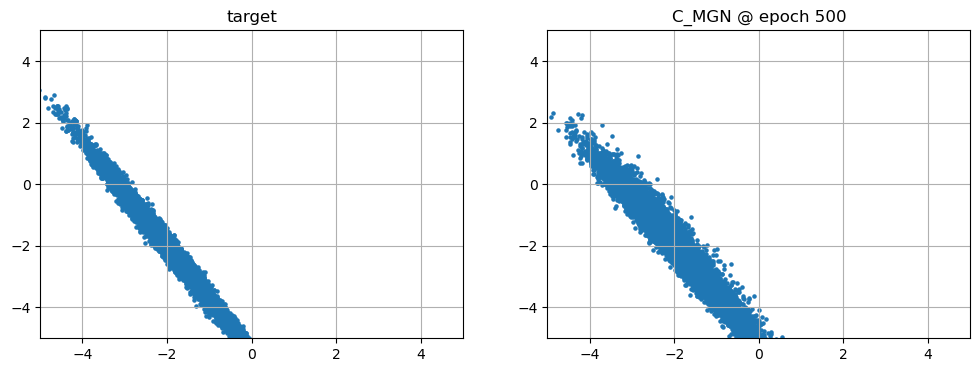

epoch 1000/3000, loss = 5.910710e-04
delta between mus = 2.17e-02
delta between covs = 2.84e-02
transport cost = 4.95e+00
mu model = tensor([-1.9897, -2.0191], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7630, -1.3047],
        [-1.3047,  2.2765]], grad_fn=<DivBackward0>)



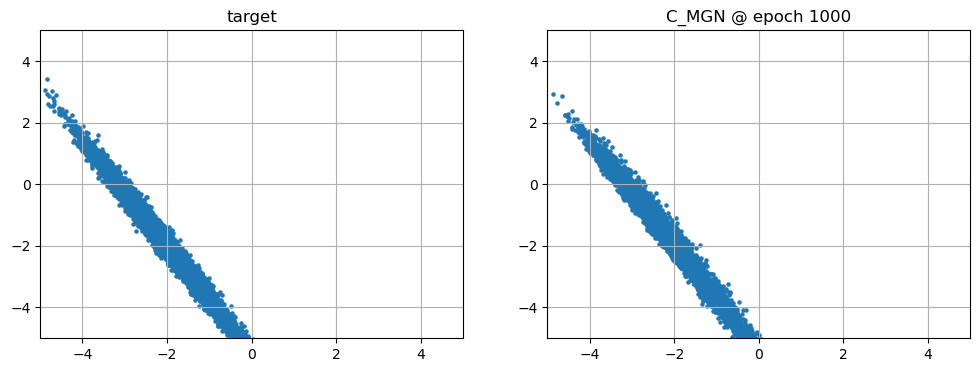

epoch 1500/3000, loss = 2.651049e-04
delta between mus = 1.56e-02
delta between covs = 1.57e-02
transport cost = 4.96e+00
mu model = tensor([-2.0112, -1.9892], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7517, -1.2867],
        [-1.2867,  2.2433]], grad_fn=<DivBackward0>)



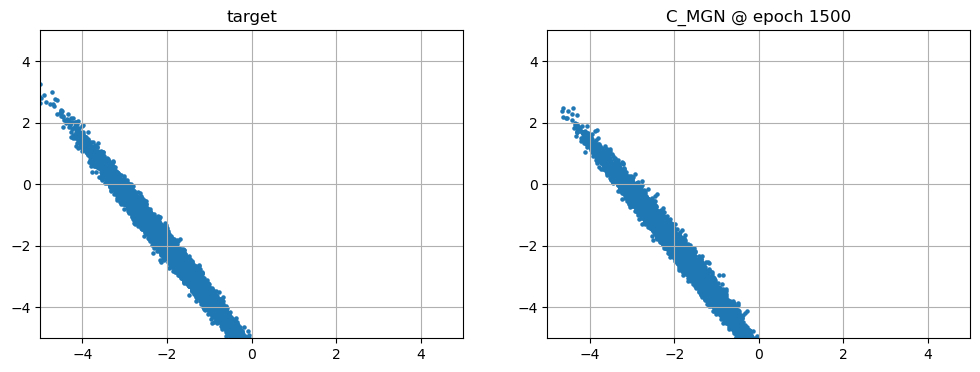

epoch 2000/3000, loss = 4.449940e-04
delta between mus = 1.65e-02
delta between covs = 4.51e-02
transport cost = 4.97e+00
mu model = tensor([-1.9939, -2.0154], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7725, -1.3163],
        [-1.3163,  2.2821]], grad_fn=<DivBackward0>)



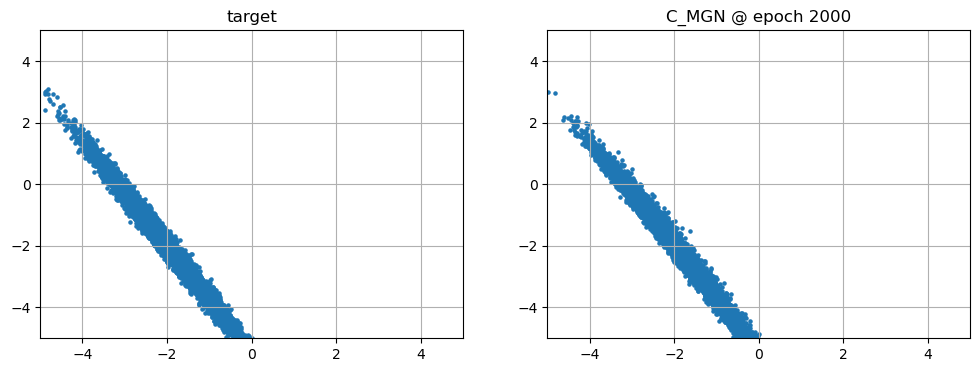

epoch 2500/3000, loss = 2.513993e-04
delta between mus = 1.39e-02
delta between covs = 2.09e-02
transport cost = 4.94e+00
mu model = tensor([-2.0052, -2.0129], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7531, -1.2962],
        [-1.2962,  2.2729]], grad_fn=<DivBackward0>)



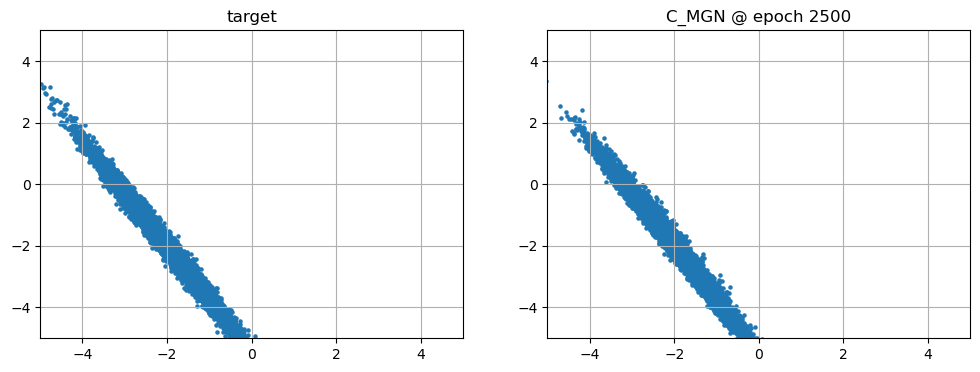

epoch 3000/3000, loss = 2.910239e-04
delta between mus = 1.53e-02
delta between covs = 2.59e-02
transport cost = 4.92e+00
mu model = tensor([-2.0081, -1.9871], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7496, -1.2825],
        [-1.2825,  2.2348]], grad_fn=<DivBackward0>)



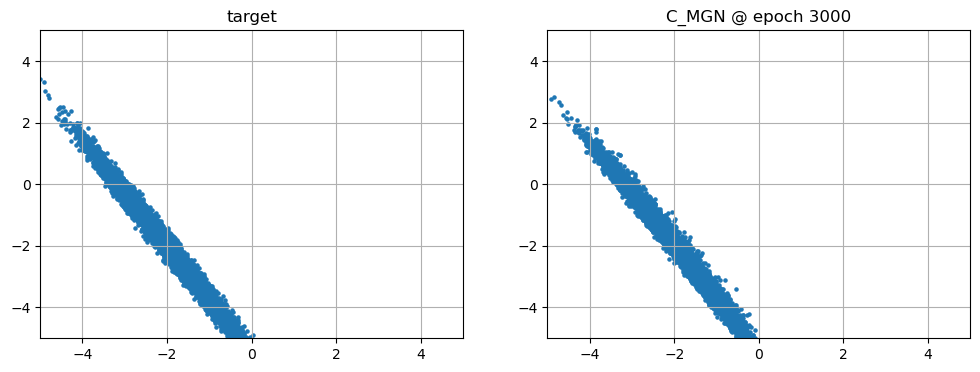

In [21]:
model_CMGN = CMGN(input_dim=2, output_dim=2, num_layers=2, hidden_dim=2)

print("Training C-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_CMGN, 
    wasserstein_2, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=3000, 
    batch_size=10000,
    model_name='C_MGN'
    )

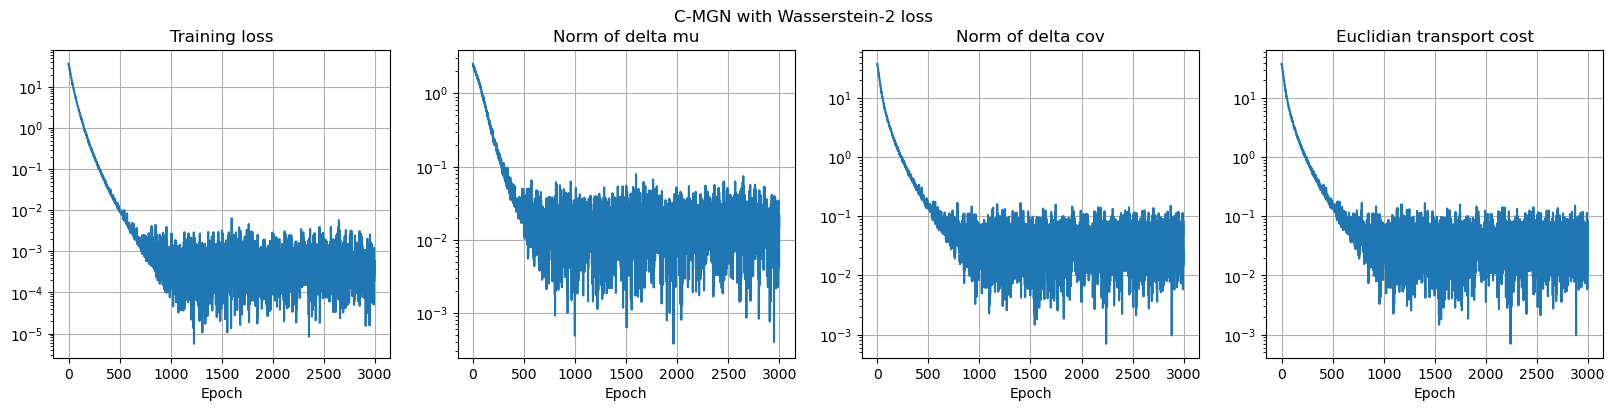

In [22]:
plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs, main_title=f"C-MGN with Wasserstein-2 loss")

M-MGN

Training M-MGN...
epoch 5000/30000, loss = 7.752914e+01
delta between mus = 5.47e-01
delta between covs = 9.68e+01
transport cost = 4.19e+01
mu model = tensor([-1.9098, -2.5399], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 5.9100,  1.0131],
        [ 1.0131, 98.8267]], grad_fn=<DivBackward0>)



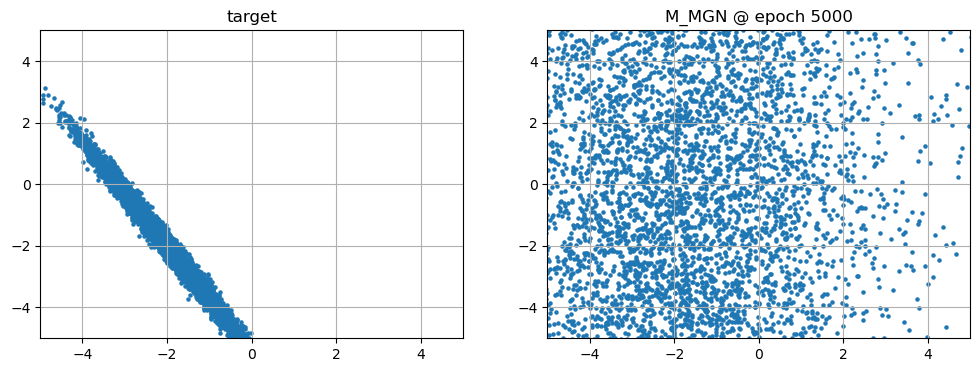

epoch 10000/30000, loss = 5.642350e+00
delta between mus = 2.25e+00
delta between covs = 2.25e+00
transport cost = 1.01e+01
mu model = tensor([-1.3149, -4.1407], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.6655, -1.2899],
        [-1.2899,  4.4982]], grad_fn=<DivBackward0>)



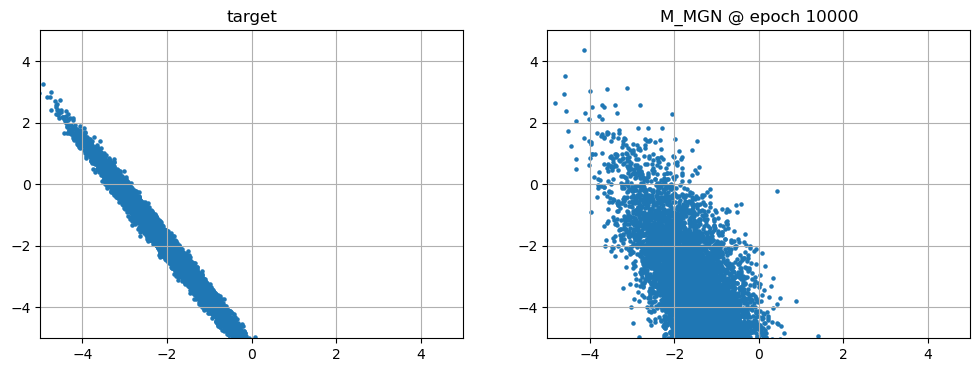

epoch 15000/30000, loss = 5.922608e-01
delta between mus = 7.55e-01
delta between covs = 9.71e-02
transport cost = 3.91e+00
mu model = tensor([-1.2713, -2.1979], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7761, -1.2788],
        [-1.2788,  2.3451]], grad_fn=<DivBackward0>)



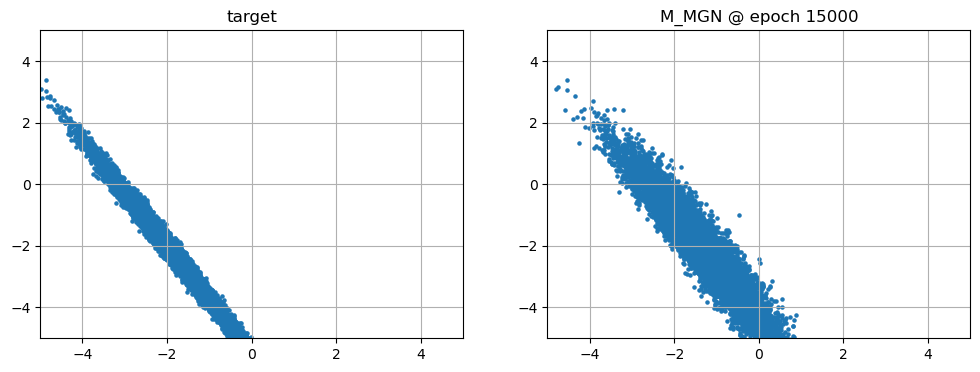

epoch 20000/30000, loss = 3.613155e-01
delta between mus = 5.94e-01
delta between covs = 7.46e-02
transport cost = 3.38e+00
mu model = tensor([-1.4750, -1.7211], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7864, -1.3100],
        [-1.3100,  2.3178]], grad_fn=<DivBackward0>)



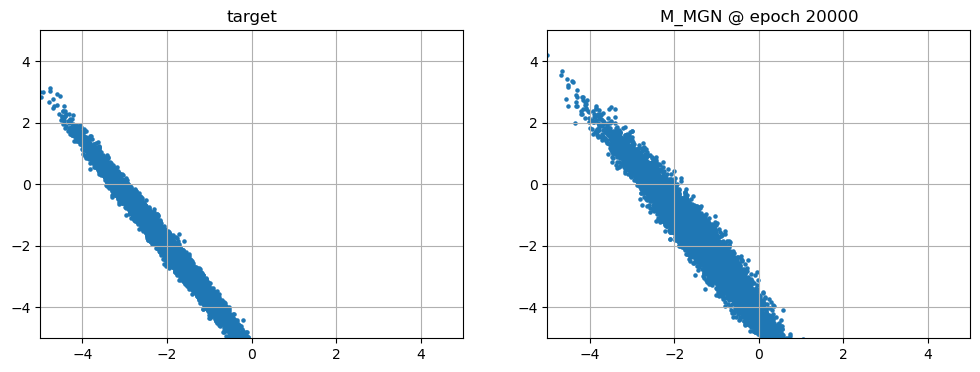

epoch 25000/30000, loss = 2.821925e-01
delta between mus = 5.09e-01
delta between covs = 3.43e-01
transport cost = 3.73e+00
mu model = tensor([-1.5026, -1.8933], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.8889, -1.4355],
        [-1.4355,  2.4987]], grad_fn=<DivBackward0>)



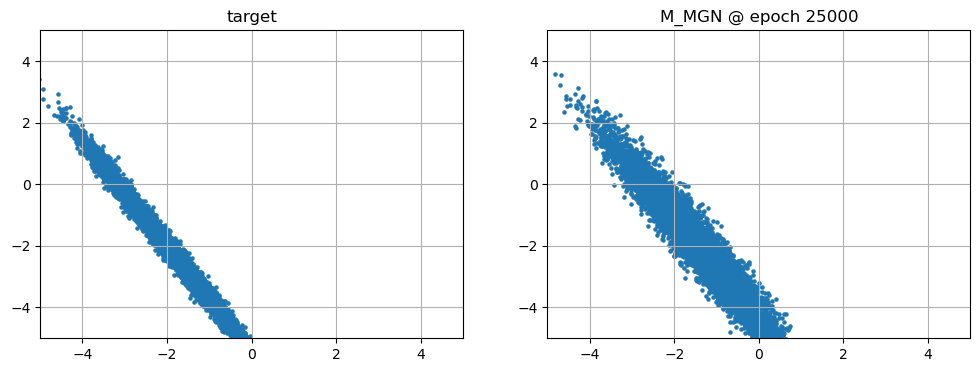

epoch 30000/30000, loss = 8.792613e-01
delta between mus = 9.38e-01
delta between covs = 1.47e-02
transport cost = 4.52e+00
mu model = tensor([-1.1708, -2.4378], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7518, -1.2872],
        [-1.2872,  2.2441]], grad_fn=<DivBackward0>)



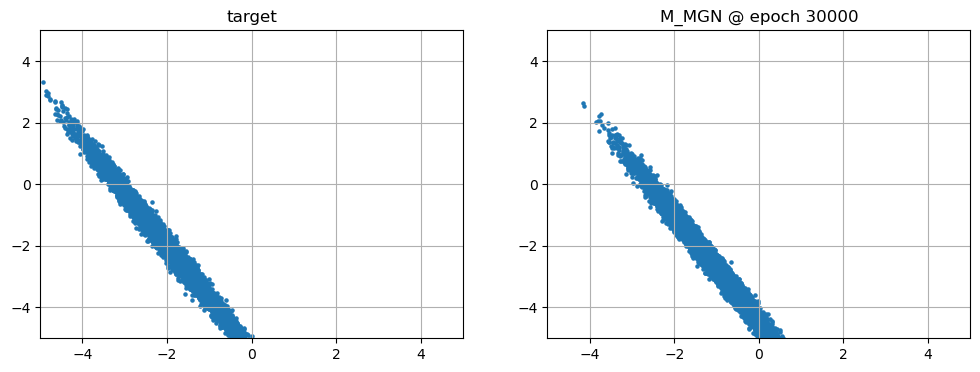

In [23]:
model_MMGN = MMGN(input_dim=2, output_dim=2, num_modules=4, hidden_dim=2)

print("Training M-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_MMGN, 
    wasserstein_2, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=30000, 
    batch_size=10000,
    model_name='M_MGN',
    display_frequency=5000
    )

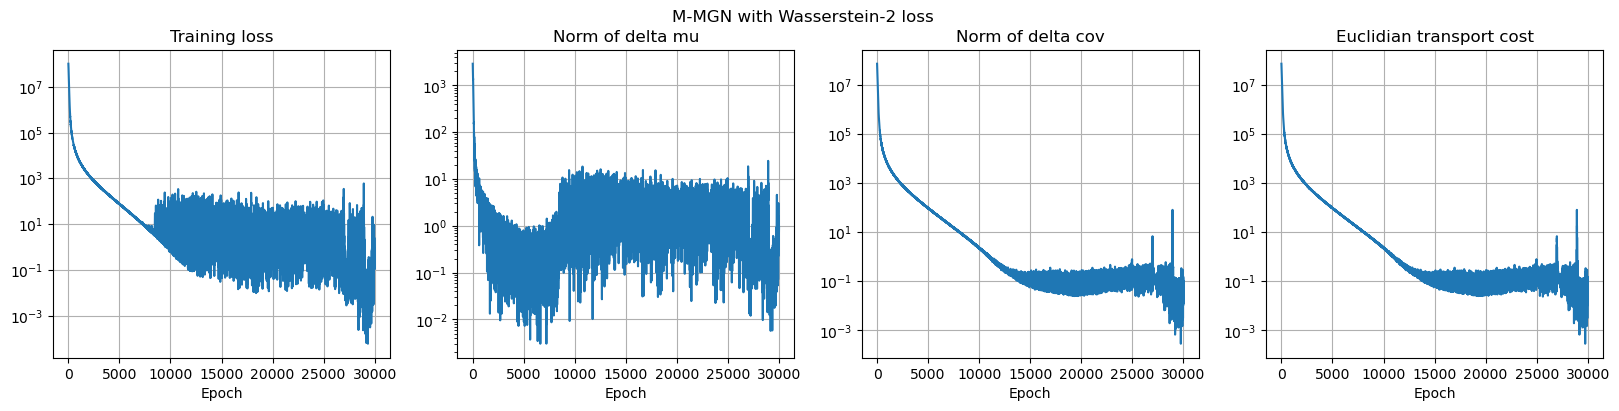

In [24]:
plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs, main_title=f"M-MGN with Wasserstein-2 loss")

### Training networks and learning transport with the KL divergence

C-MGN

Training C-MGN...


/tmp/ipykernel_3244759/1475515704.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/envs/bld/conda-bld/libtorch_1741644046984/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  kl = 1/2 * (torch.trace(sigma2_inv @ sigma1) - k + (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1) + torch.log(torch.linalg.det(sigma2) / torch.linalg.det(sigma1)))


epoch 500/3000, loss = 1.191493e+00
delta between mus = 4.98e-01
delta between covs = 4.77e-01
transport cost = 4.60e+00
mu model = tensor([-1.6292, -2.3320], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 1.1800, -1.4242],
        [-1.4242,  2.3772]], grad_fn=<DivBackward0>)



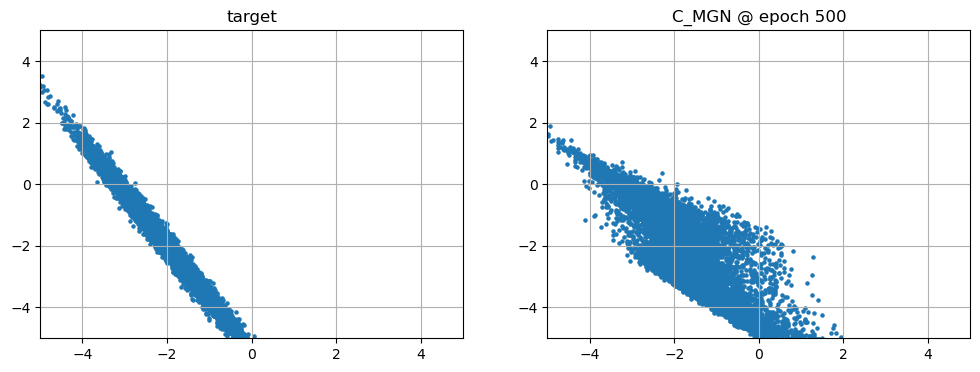

epoch 1000/3000, loss = 3.461380e-04
delta between mus = 3.76e-02
delta between covs = 1.99e-02
transport cost = 4.91e+00
mu model = tensor([-1.9806, -2.0322], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7621, -1.3030],
        [-1.3030,  2.2679]], grad_fn=<DivBackward0>)



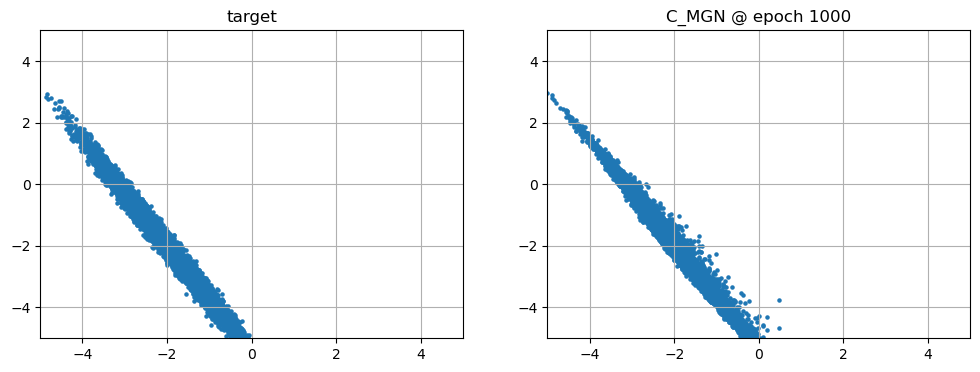

epoch 1500/3000, loss = 8.055030e-04
delta between mus = 5.48e-03
delta between covs = 8.11e-02
transport cost = 4.86e+00
mu model = tensor([-2.0043, -1.9966], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7778, -1.3295],
        [-1.3295,  2.3137]], grad_fn=<DivBackward0>)



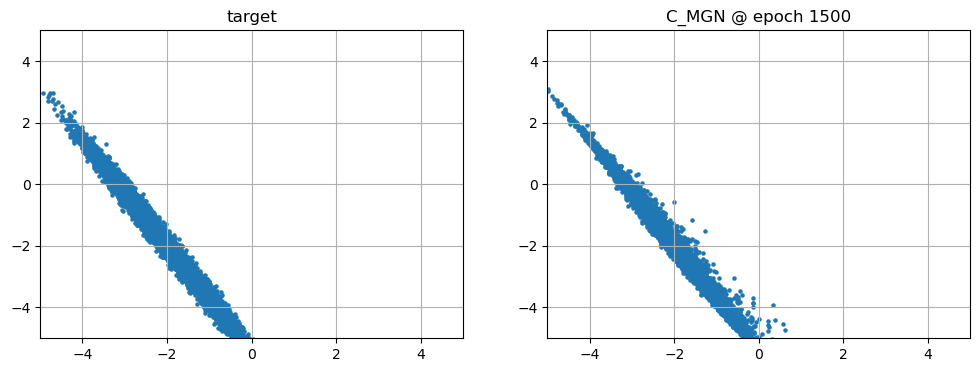

epoch 2000/3000, loss = 8.436109e-04
delta between mus = 3.44e-03
delta between covs = 1.12e-02
transport cost = 4.92e+00
mu model = tensor([-1.9973, -2.0022], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7614, -1.2996],
        [-1.2996,  2.2603]], grad_fn=<DivBackward0>)



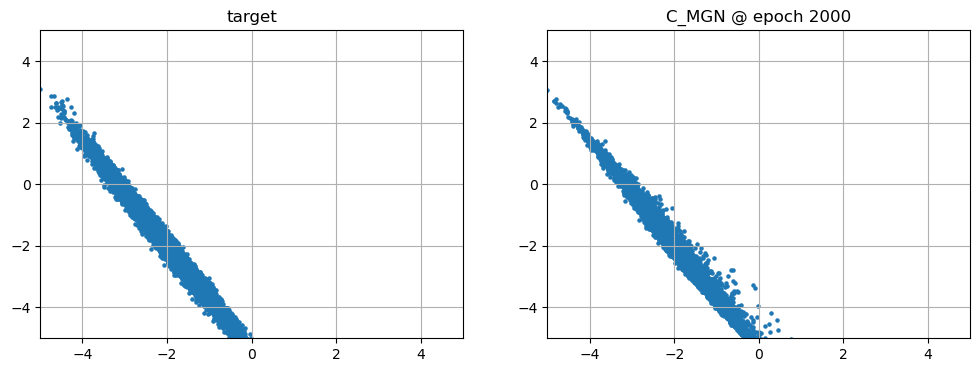

epoch 2500/3000, loss = 6.561970e-04
delta between mus = 1.51e-02
delta between covs = 5.21e-02
transport cost = 5.01e+00
mu model = tensor([-1.9907, -2.0119], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7471, -1.2739],
        [-1.2739,  2.2107]], grad_fn=<DivBackward0>)



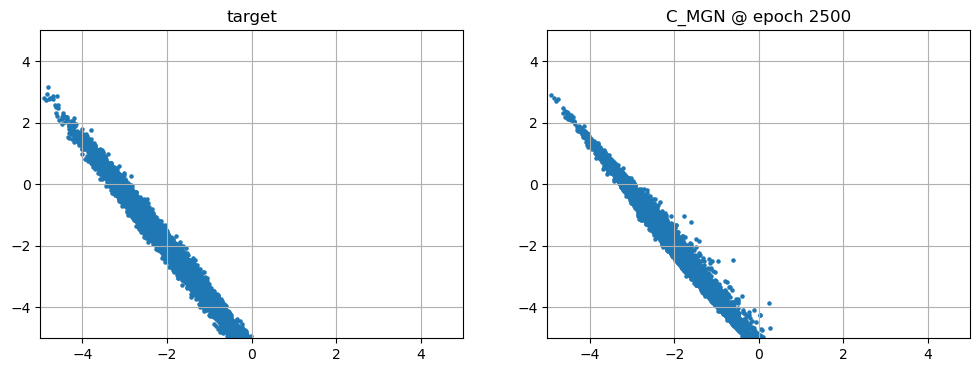

epoch 3000/3000, loss = 9.725740e-04
delta between mus = 1.17e-02
delta between covs = 1.06e-01
transport cost = 4.95e+00
mu model = tensor([-1.9919, -2.0085], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 0.7849, -1.3410],
        [-1.3410,  2.3318]], grad_fn=<DivBackward0>)



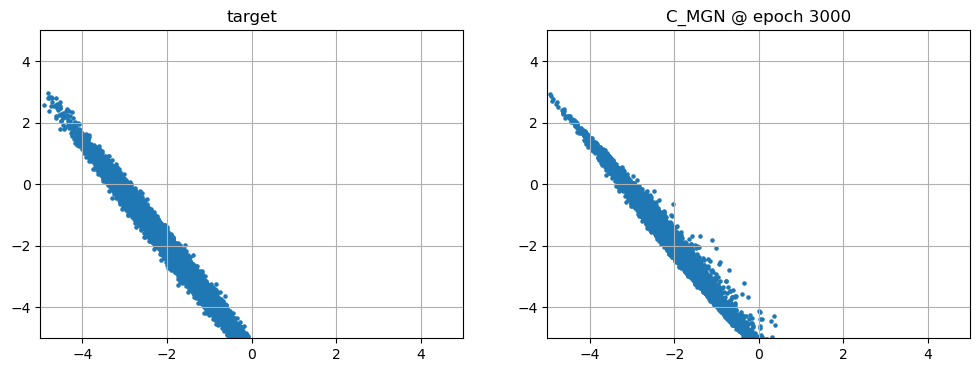

In [25]:
model_CMGN = CMGN(input_dim=2, output_dim=2, num_layers=2, hidden_dim=2)

print("Training C-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_CMGN, 
    KL, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=3000, 
    batch_size=10000,
    model_name='C_MGN'
    )

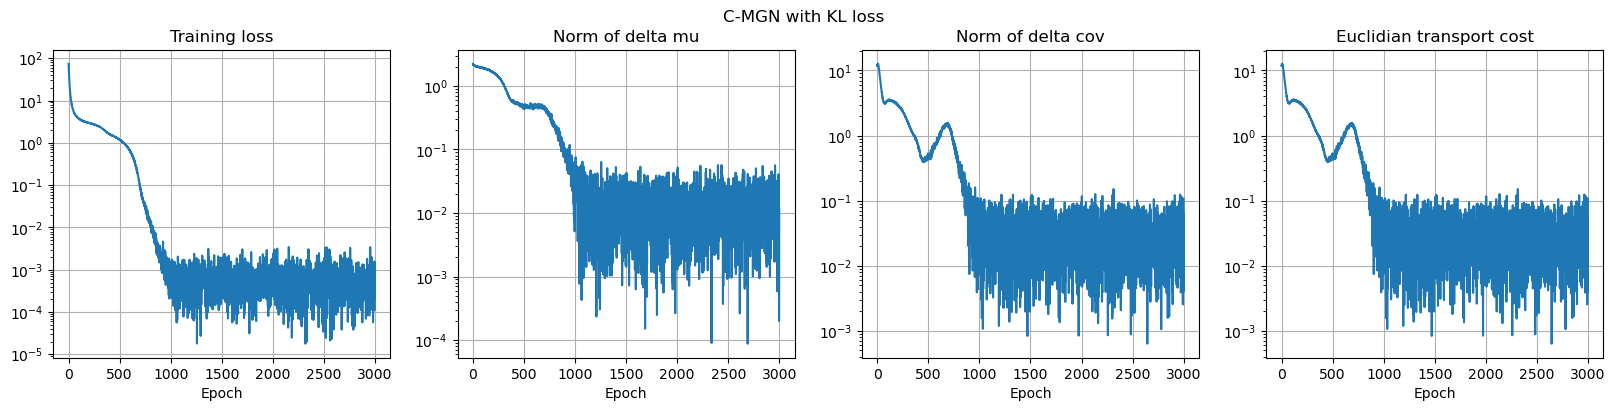

In [26]:
plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs, main_title=f"C-MGN with KL loss")

M-MGN

Training M-MGN...
epoch 5000/50000, loss = 7.450074e+00
delta between mus = 1.33e+00
delta between covs = 5.21e+03
transport cost = 2.57e+03
mu model = tensor([-3.1364, -1.3013], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 4025.1774, -2154.6948],
        [-2154.6948,  1315.1604]], grad_fn=<DivBackward0>)



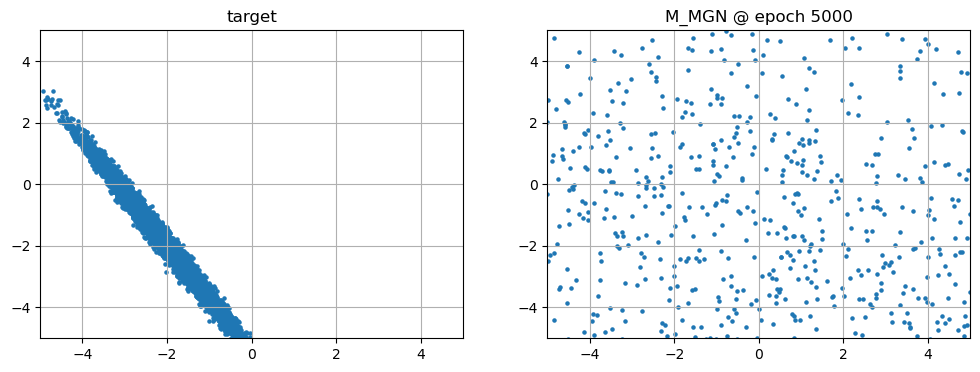

epoch 10000/50000, loss = 3.412235e+00
delta between mus = 1.56e+00
delta between covs = 1.41e+01
transport cost = 1.12e+01
mu model = tensor([-1.5353, -3.4872], grad_fn=<MeanBackward1>)
cov model = 
tensor([[13.4138,  1.0574],
        [ 1.0574,  7.5075]], grad_fn=<DivBackward0>)



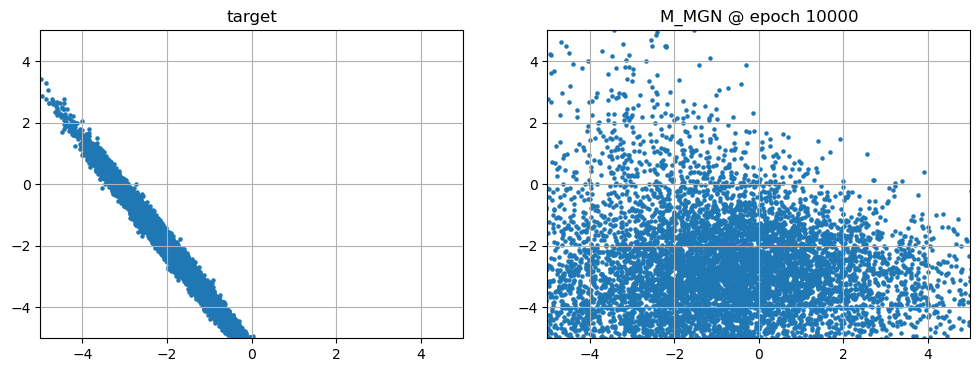

epoch 15000/50000, loss = 4.671945e+00
delta between mus = 5.30e-01
delta between covs = 1.03e+02
transport cost = 4.94e+01
mu model = tensor([-2.5300, -2.0132], grad_fn=<MeanBackward1>)
cov model = 
tensor([[96.0568, 20.0400],
        [20.0400, 27.2550]], grad_fn=<DivBackward0>)



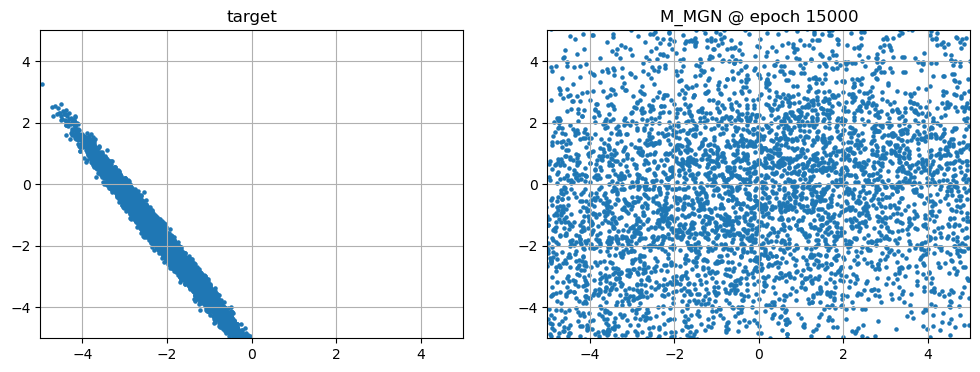

epoch 20000/50000, loss = 3.452004e+00
delta between mus = 2.66e+00
delta between covs = 7.98e+00
transport cost = 1.44e+01
mu model = tensor([-4.6481, -1.7944], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 6.4082, -0.0464],
        [-0.0464,  7.6079]], grad_fn=<DivBackward0>)



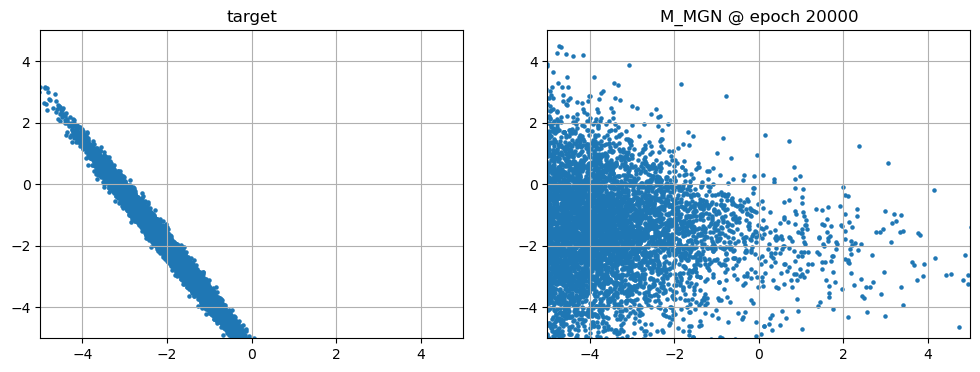

epoch 25000/50000, loss = 4.171287e+00
delta between mus = 3.33e-01
delta between covs = 4.04e+01
transport cost = 2.09e+01
mu model = tensor([-2.0642, -1.6735], grad_fn=<MeanBackward1>)
cov model = 
tensor([[23.9056, -0.4533],
        [-0.4533, 35.3364]], grad_fn=<DivBackward0>)



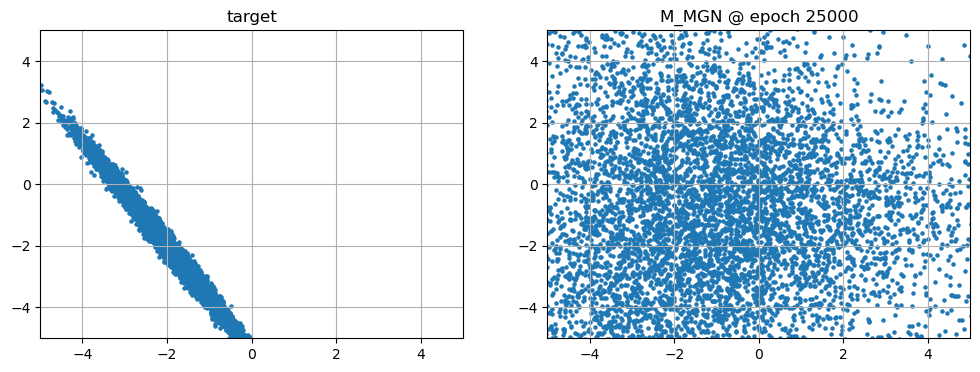

epoch 30000/50000, loss = 4.594567e+00
delta between mus = 2.47e-02
delta between covs = 6.19e+01
transport cost = 3.41e+01
mu model = tensor([-2.0141, -1.9797], grad_fn=<MeanBackward1>)
cov model = 
tensor([[43.0744,  2.0810],
        [ 2.0810, 47.1637]], grad_fn=<DivBackward0>)



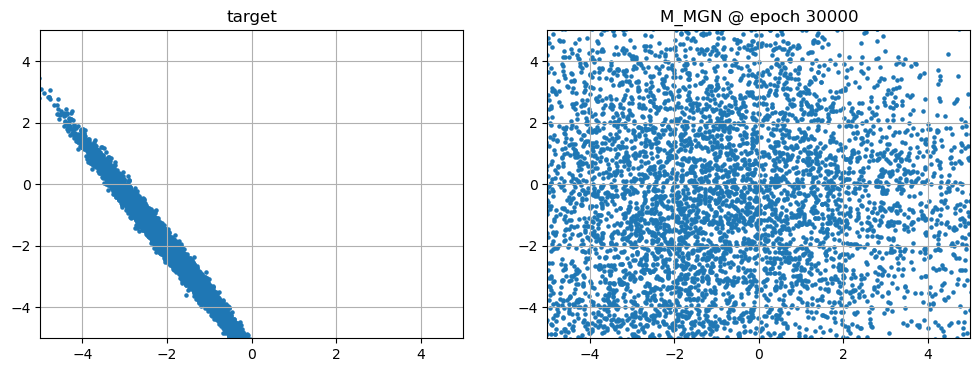

epoch 35000/50000, loss = 4.143183e+00
delta between mus = 2.50e+00
delta between covs = 6.69e+01
transport cost = 3.48e+01
mu model = tensor([-0.4111, -3.9323], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 14.2442, -15.1409],
        [-15.1409,  64.7367]], grad_fn=<DivBackward0>)



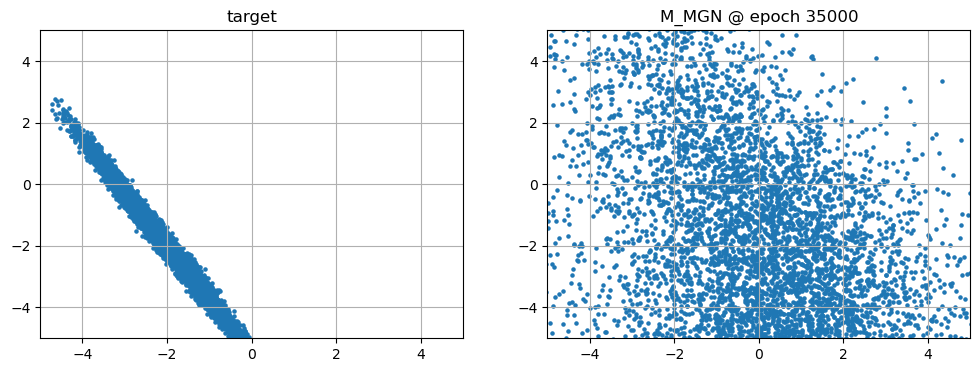

epoch 40000/50000, loss = 3.173267e+00
delta between mus = 4.86e-01
delta between covs = 1.16e+01
transport cost = 7.72e+00
mu model = tensor([-2.3725, -1.6874], grad_fn=<MeanBackward1>)
cov model = 
tensor([[ 9.0403, -0.7128],
        [-0.7128, 10.3548]], grad_fn=<DivBackward0>)



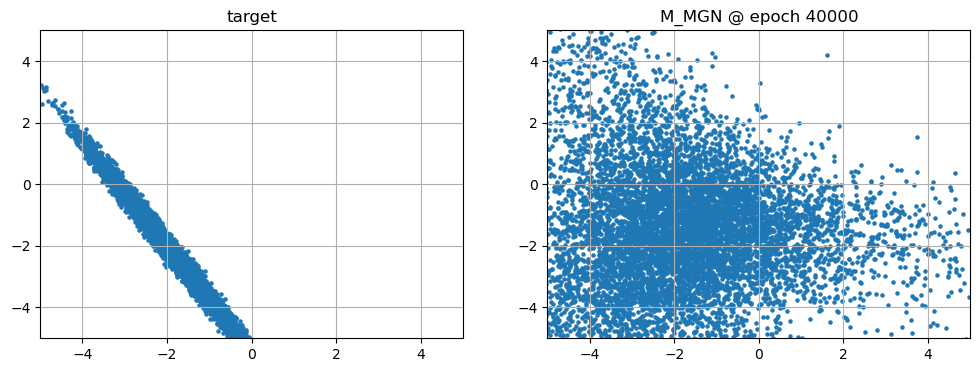

epoch 45000/50000, loss = 4.309162e+00
delta between mus = 3.77e-01
delta between covs = 4.73e+01
transport cost = 2.50e+01
mu model = tensor([-1.6777, -2.1954], grad_fn=<MeanBackward1>)
cov model = 
tensor([[27.1665,  1.1183],
        [ 1.1183, 41.3025]], grad_fn=<DivBackward0>)



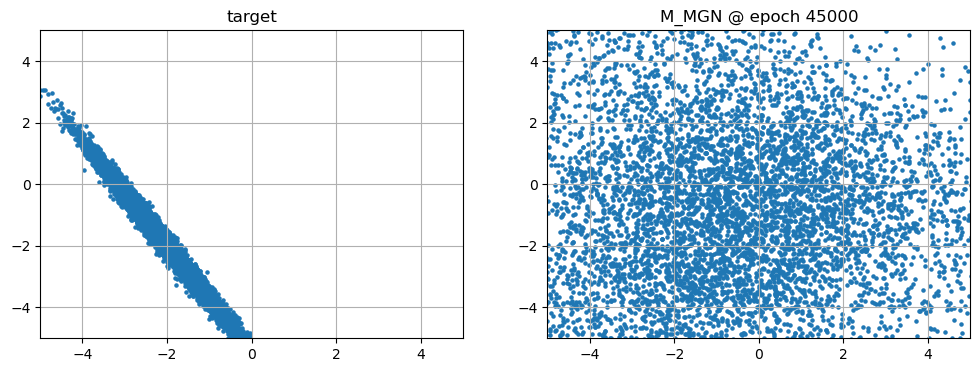

epoch 50000/50000, loss = 3.506754e+00
delta between mus = 8.66e-01
delta between covs = 2.00e+01
transport cost = 1.32e+01
mu model = tensor([-2.0604, -2.8640], grad_fn=<MeanBackward1>)
cov model = 
tensor([[10.0436, -1.2495],
        [-1.2495, 20.0037]], grad_fn=<DivBackward0>)



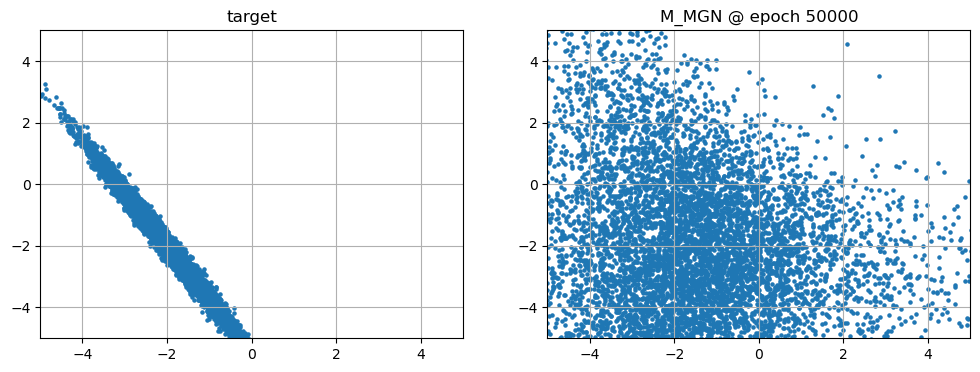

In [27]:
model_MMGN = MMGN(input_dim=2, output_dim=2, num_modules=2, hidden_dim=2)

print("Training M-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_MMGN, 
    KL, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=50000, 
    batch_size=10000,
    model_name='M_MGN',
    display_frequency=5000,
    lr=1e-2
    )

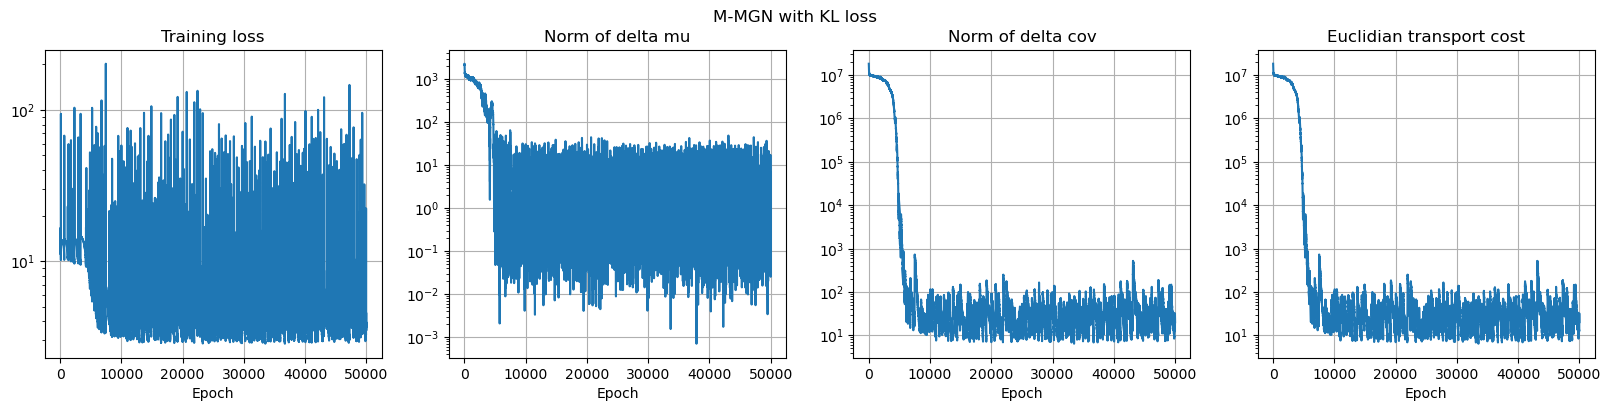

In [28]:
plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs, main_title=f"M-MGN with KL loss")

## Summary of Toy case #2 :

- again, both models C-MGN and M-MGN, with two different loss functions (Wasserstein 2 and KL divergence)
- the convergence remains faster, and more stable, with C-MGN, even though we increased the number of modules of M-MGN.
- training M-MGN with KL divergence is difficult. We had to tune the learning rate and the number of epochs

# Color domain adaptation

Here, we want to take a daytime image, and transport its color distribution to the one of either a sunset image, or a nightime image

### Sunset

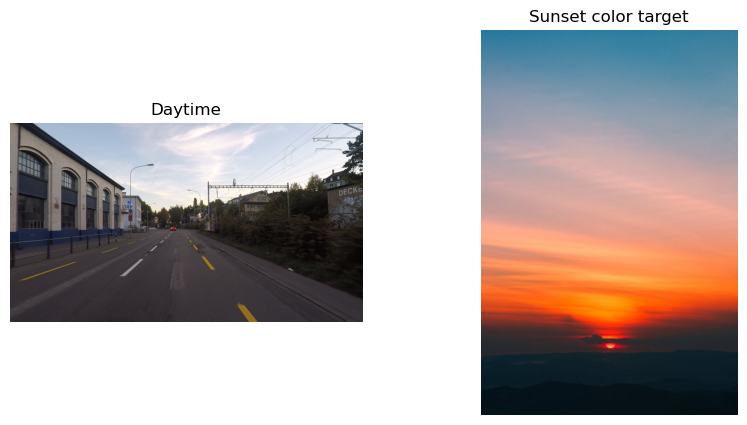

In [29]:
cwd = os.getcwd()

daytime_path = cwd + '/Day.png'
sunset_path = cwd + '/sunset.jpg'

daytime_image_raw = imread(daytime_path)
sunset_image_raw = imread(sunset_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(daytime_image_raw)
ax[0].set_title('Daytime')
ax[1].imshow(sunset_image_raw)
ax[1].set_title('Sunset color target')
for a in ax:
    a.axis('off')
plt.show()

In [30]:
def transform(image1_raw, image2_raw):
    """utility function, reshape, normalize, move to device, estimate Gaussians, returns tensors
    """
    image1 = image1_raw.reshape(-1, 3)
    image2 = image2_raw.reshape(-1, 3)
    
    image1 = image1 / image1.max(axis=0)
    image2 = image2 / image2.max(axis=0)
    
    image1 = torch.tensor(image1, dtype=torch.double).to(device)
    image2 = torch.tensor(image2, dtype=torch.double).to(device)
    
    # fit two Gaussians
    mu_s = image1.mean(dim=0)
    cov_s = torch.mm((image1 - mu_s).T, image1 - mu_s) / image1.shape[0]
    mu_t = image2.mean(dim=0)
    cov_t = torch.mm((image2 - mu_t).T, image2 - mu_t) / image2.shape[0]
    
    # donne des nouvelles
    print(f"Color distribution of the first image is approximated by a 3-d Gaussian:")
    print(f"mu_s = {mu_s}")
    print(f"cov_s = ")
    print(f"{cov_s}")
    print()
    print(f"Color distribution of the second image is approximated by a 3-d Gaussian:")
    print(f"mu_t = {mu_t}")
    print(f"cov_t = ")
    print(f"{cov_t}")
    
    return image1, image2, mu_s, cov_s, mu_t, cov_t

In [31]:
daytime_image, sunset_image, mu_s, cov_s, mu_t, cov_t = transform(daytime_image_raw, sunset_image_raw)

Color distribution of the first image is approximated by a 3-d Gaussian:
mu_s = tensor([0.3987, 0.3900, 0.4030])
cov_s = 
tensor([[0.0888, 0.0917, 0.0939],
        [0.0917, 0.0953, 0.0983],
        [0.0939, 0.0983, 0.1026]])

Color distribution of the second image is approximated by a 3-d Gaussian:
mu_t = tensor([0.5672, 0.5590, 0.6061])
cov_t = 
tensor([[0.1196, 0.0638, 0.0287],
        [0.0638, 0.0680, 0.0736],
        [0.0287, 0.0736, 0.1144]])


Training C-MGN...
epoch 1000/3000, loss = 6.008127e-04
delta between mus = 3.42e-03
delta between covs = 1.12e-02
transport cost = 5.66e-02
mu model = tensor([0.5695, 0.5571, 0.6045], grad_fn=<MeanBackward1>)
cov model = 
tensor([[0.1170, 0.0599, 0.0318],
        [0.0599, 0.0679, 0.0732],
        [0.0318, 0.0732, 0.1061]], grad_fn=<DivBackward0>)



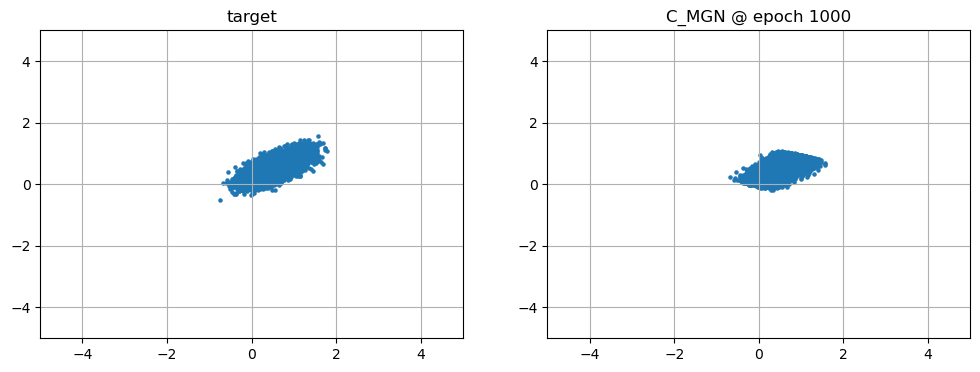

epoch 2000/3000, loss = 7.459063e-05
delta between mus = 2.58e-03
delta between covs = 2.78e-03
transport cost = 5.84e-02
mu model = tensor([0.5673, 0.5615, 0.6069], grad_fn=<MeanBackward1>)
cov model = 
tensor([[0.1200, 0.0647, 0.0300],
        [0.0647, 0.0689, 0.0731],
        [0.0300, 0.0731, 0.1133]], grad_fn=<DivBackward0>)



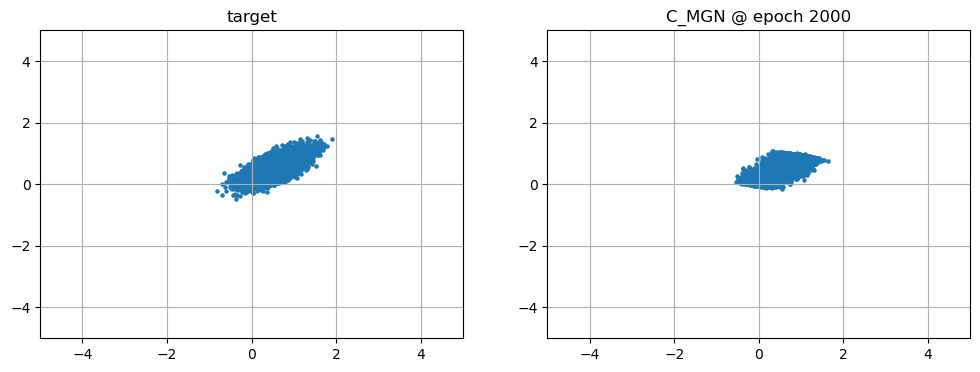

epoch 3000/3000, loss = 1.094361e-04
delta between mus = 7.19e-03
delta between covs = 4.75e-03
transport cost = 5.92e-02
mu model = tensor([0.5729, 0.5565, 0.6025], grad_fn=<MeanBackward1>)
cov model = 
tensor([[0.1198, 0.0646, 0.0312],
        [0.0646, 0.0685, 0.0746],
        [0.0312, 0.0746, 0.1169]], grad_fn=<DivBackward0>)



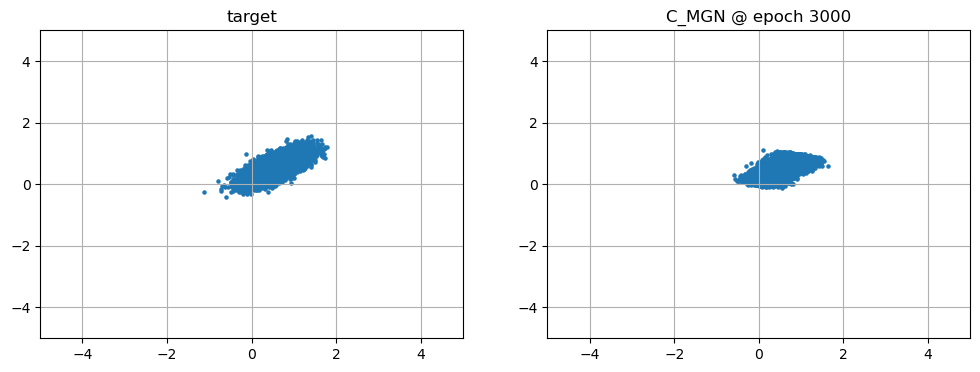

In [32]:
# now, we learn the transport between from the source distribution to the target distribution

model_CMGN = CMGN(input_dim=3, output_dim=3, num_layers=2, hidden_dim=3)

print("Training C-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_CMGN, 
    wasserstein_2, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=3000, 
    batch_size=10000,
    model_name='C_MGN',
    display_frequency=1000
    )

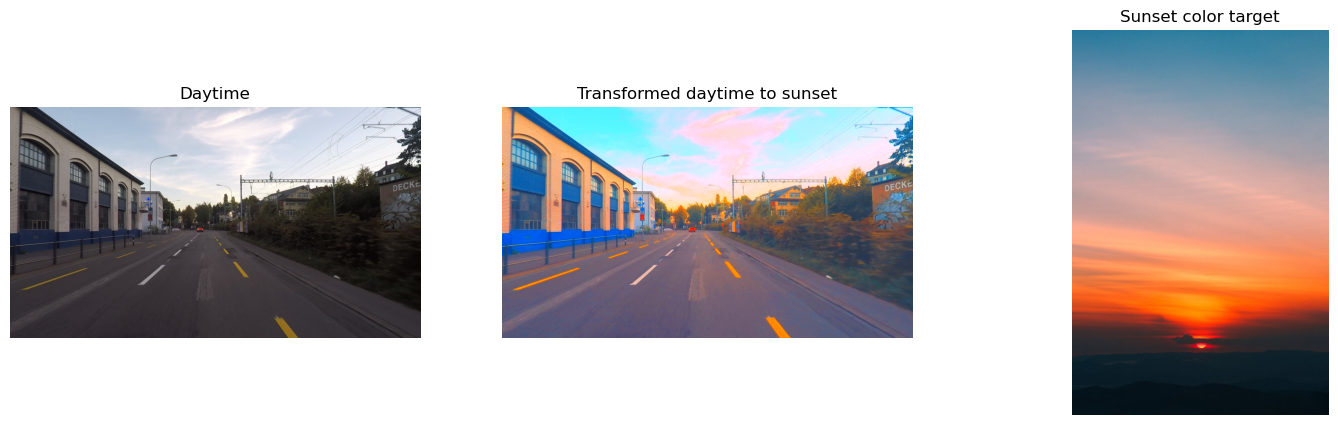

In [33]:
# transform the daytime image with the transported color distribution

daytime_image_transformed = model_CMGN(daytime_image)
daytime_image_transformed = torch.clamp(daytime_image_transformed, 0, 1)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].imshow(daytime_image_raw)
ax[0].set_title('Daytime')
ax[1].imshow(daytime_image_transformed.cpu().detach().numpy().reshape(daytime_image_raw.shape))
ax[1].set_title('Transformed daytime to sunset')
ax[2].imshow(sunset_image_raw)
ax[2].set_title('Sunset color target')
for a in ax:
    a.axis('off')

plt.show()

### Nighttime

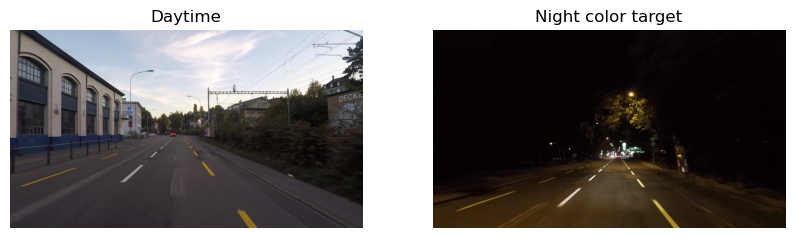

In [34]:
cwd = os.getcwd()

daytime_path = cwd + '/Day.png'
nighttime_path = cwd + '/Night.png'

daytime_image_raw = imread(daytime_path)
nighttime_image_raw = imread(nighttime_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(daytime_image_raw)
ax[0].set_title('Daytime')
ax[1].imshow(nighttime_image_raw)
ax[1].set_title('Night color target')
for a in ax:
    a.axis('off')
plt.show()

In [35]:
daytime_image, night_image, mu_s, cov_s, mu_t, cov_t = transform(daytime_image_raw, nighttime_image_raw)

Color distribution of the first image is approximated by a 3-d Gaussian:
mu_s = tensor([0.3987, 0.3900, 0.4030])
cov_s = 
tensor([[0.0888, 0.0917, 0.0939],
        [0.0917, 0.0953, 0.0983],
        [0.0939, 0.0983, 0.1026]])

Color distribution of the second image is approximated by a 3-d Gaussian:
mu_t = tensor([0.0870, 0.0560, 0.0321])
cov_t = 
tensor([[0.0125, 0.0103, 0.0061],
        [0.0103, 0.0087, 0.0054],
        [0.0061, 0.0054, 0.0040]])


Training C-MGN...
epoch 1000/3000, loss = 6.110187e-03
delta between mus = 1.36e-03
delta between covs = 1.03e-02
transport cost = 1.68e-01
mu model = tensor([0.0878, 0.0557, 0.0332], grad_fn=<MeanBackward1>)
cov model = 
tensor([[0.0141, 0.0116, 0.0026],
        [0.0116, 0.0109, 0.0013],
        [0.0026, 0.0013, 0.0102]], grad_fn=<DivBackward0>)



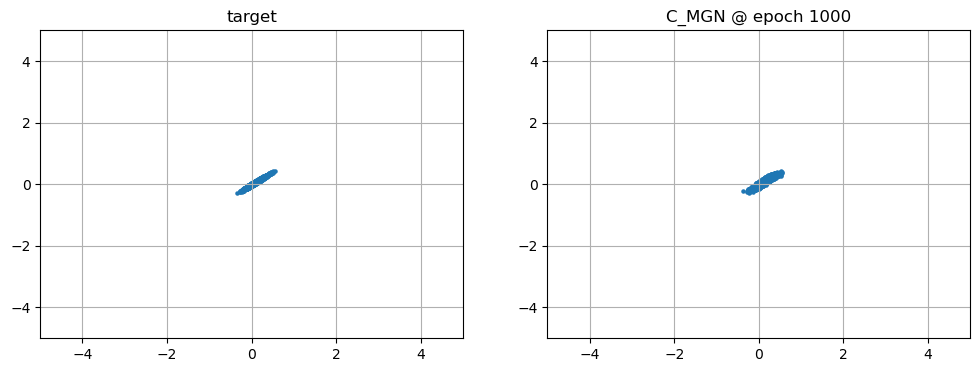

epoch 2000/3000, loss = 1.925240e-03
delta between mus = 7.43e-04
delta between covs = 3.87e-03
transport cost = 1.65e-01
mu model = tensor([0.0877, 0.0560, 0.0322], grad_fn=<MeanBackward1>)
cov model = 
tensor([[0.0134, 0.0105, 0.0047],
        [0.0105, 0.0094, 0.0041],
        [0.0047, 0.0041, 0.0065]], grad_fn=<DivBackward0>)



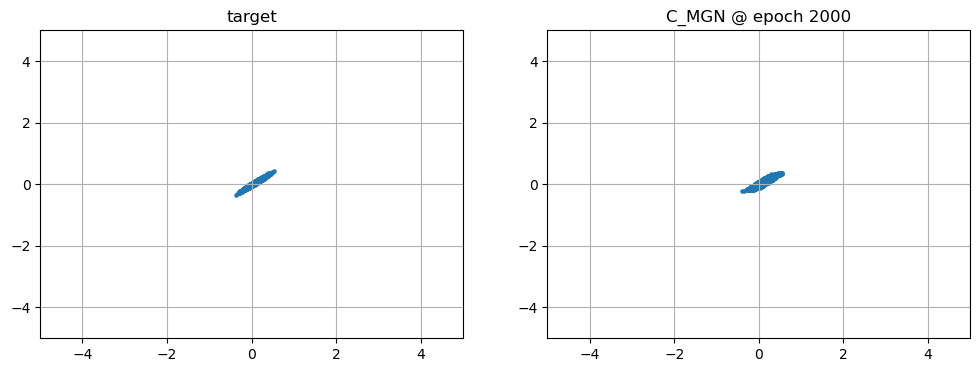

epoch 3000/3000, loss = 6.909915e-04
delta between mus = 2.12e-03
delta between covs = 1.61e-03
transport cost = 1.65e-01
mu model = tensor([0.0849, 0.0559, 0.0318], grad_fn=<MeanBackward1>)
cov model = 
tensor([[0.0130, 0.0103, 0.0055],
        [0.0103, 0.0092, 0.0049],
        [0.0055, 0.0049, 0.0049]], grad_fn=<DivBackward0>)



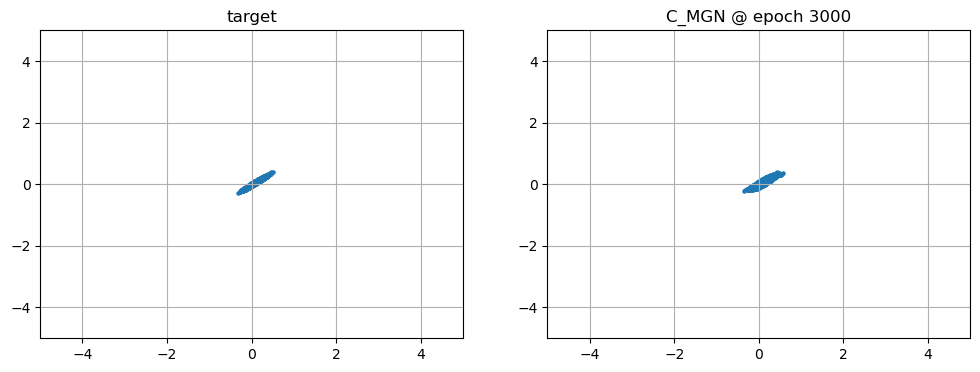

In [36]:
# now, we learn the transport between from the source distribution to the target distribution

model_CMGN = CMGN(input_dim=3, output_dim=3, num_layers=2, hidden_dim=3)

print("Training C-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_CMGN, 
    wasserstein_2, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=3000, 
    batch_size=10000,
    model_name='C_MGN',
    display_frequency=1000
    )

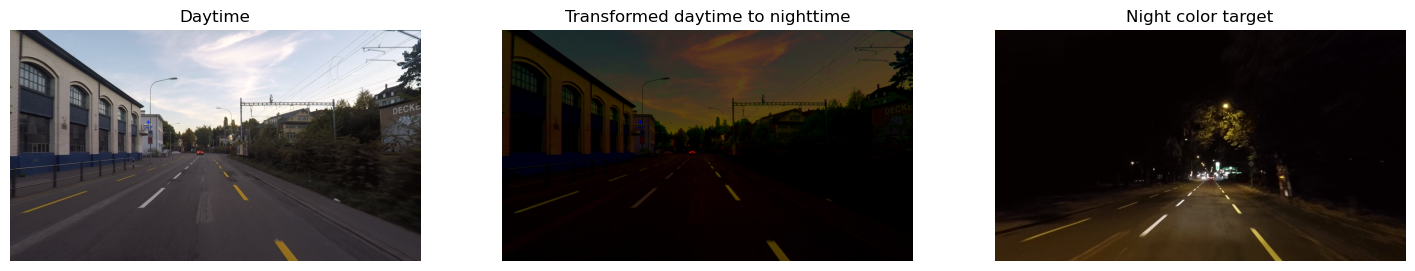

In [37]:
# transform the daytime image with the transported color distribution

daytime_image_transformed = model_CMGN(daytime_image)
daytime_image_transformed = torch.clamp(daytime_image_transformed, 0, 1)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].imshow(daytime_image_raw)
ax[0].set_title('Daytime')
ax[1].imshow(daytime_image_transformed.cpu().detach().numpy().reshape(daytime_image_raw.shape))
ax[1].set_title('Transformed daytime to nighttime')
ax[2].imshow(nighttime_image_raw)
ax[2].set_title('Night color target')
for a in ax:
    a.axis('off')

plt.show()